# Установка PySpark

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=5ee70944b36b927ef0db411dd4e5027952daa42e8df62eca1c023f269fefd192
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


# Импорт необходимых инструментов

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, col

# Чтение и обработка данных

In [ ]:
# создание SparkSession
spark = SparkSession.builder.appName('BooksAuthorsAnalysis').getOrCreate()

# чтение данных
books_df = spark.read.csv('/content/drive/MyDrive/books.csv', header=True, inferSchema=True)
authors_df = spark.read.csv('/content/drive/MyDrive/authors.csv', header=True, inferSchema=True)

# преобразование столбцов publish_date и birth_date в формат даты
books_df = books_df.withColumn('publish_date', to_date(col('publish_date'), 'yyyy-MM-dd'))
authors_df = authors_df.withColumn('birth_date', to_date(col('birth_date'), 'yyyy-MM-dd'))

# объединение books_df и authors_df в один датафрейм
df = authors_df.join(books_df, 'author_id', 'inner')

df.show()

+---------+---------+----------+---------+-------+-------+-----------+-----+------------+
|author_id|     name|birth_date|  country|book_id|  title|      genre|price|publish_date|
+---------+---------+----------+---------+-------+-------+-----------+-----+------------+
|        2| Author_2|1965-12-31|   Canada|      1| Book_1|    Mystery|73.57|  1980-12-31|
|        1| Author_1|1960-12-31|    India|      2| Book_2|Non-Fiction| 41.1|  1982-12-31|
|       10|Author_10|2005-12-31|    India|      3| Book_3|    Fiction|10.63|  1984-12-31|
|        9| Author_9|2000-12-31|Australia|      4| Book_4|Non-Fiction|46.31|  1986-12-31|
|        7| Author_7|1990-12-31|      USA|      5| Book_5|    Science|31.13|  1988-12-31|
|        4| Author_4|1975-12-31|       UK|      6| Book_6|Non-Fiction| 83.7|  1990-12-31|
|        6| Author_6|1985-12-31|      USA|      7| Book_7|Non-Fiction|40.36|  1992-12-31|
|        2| Author_2|1965-12-31|   Canada|      8| Book_8|Non-Fiction|84.48|  1994-12-31|
|        7

# Анализ данных

In [ ]:
# регистрация датафрейма как временной таблицы
df.createOrReplaceTempView('df')

# топ 5 авторов по выручке
top5_authors_df = spark.sql('''
    SELECT author_id, name, SUM(price) AS total_price
    FROM df
    GROUP BY author_id, name
    ORDER BY total_price DESC
    LIMIT 5
''')

top5_authors_df.show()
top5_authors_data = top5_authors_df.collect()

# количество книг по жанрам
quantity_by_genre_df = spark.sql('''
    SELECT genre, COUNT(book_id) AS quantity
    FROM df
    GROUP BY genre
    ORDER BY quantity DESC
''')

quantity_by_genre_df.show()
quantity_by_genre_data = quantity_by_genre_df.collect()

# средняя цена книг по авторам
avg_price_by_authors_df = spark.sql('''
    SELECT author_id, name, ROUND(AVG(price), 2) AS average_price
    FROM df
    GROUP BY author_id, name
    ORDER BY average_price DESC
''')

avg_price_by_authors_df.show()
avg_price_by_authors_data = avg_price_by_authors_df.collect()

books_after_2000_df = spark.sql('select * from df where year(publish_date) > 2000 order by price desc')

books_after_2000_df.show()

+---------+--------+-----------+
|author_id|    name|total_price|
+---------+--------+-----------+
|        2|Author_2|     231.97|
|        7|Author_7|     132.66|
|        1|Author_1|     111.86|
|        8|Author_8|     107.16|
|        5|Author_5|      88.83|
+---------+--------+-----------+

+-----------+--------+
|      genre|quantity|
+-----------+--------+
|Non-Fiction|       9|
|    Science|       3|
|    Fiction|       3|
|    Fantasy|       3|
|    Mystery|       2|
+-----------+--------+

+---------+---------+-------------+
|author_id|     name|average_price|
+---------+---------+-------------+
|        5| Author_5|        88.83|
|        4| Author_4|         83.7|
|        2| Author_2|        57.99|
|        9| Author_9|        46.31|
|        7| Author_7|        44.22|
|        6| Author_6|        43.97|
|        1| Author_1|        37.29|
|        8| Author_8|        35.72|
|       10|Author_10|        21.17|
+---------+---------+-------------+

+---------+--------+-----

# Визуализация

<ipython-input-31-0251d0890bc6>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=author_names, y=total_prices, palette='viridis')


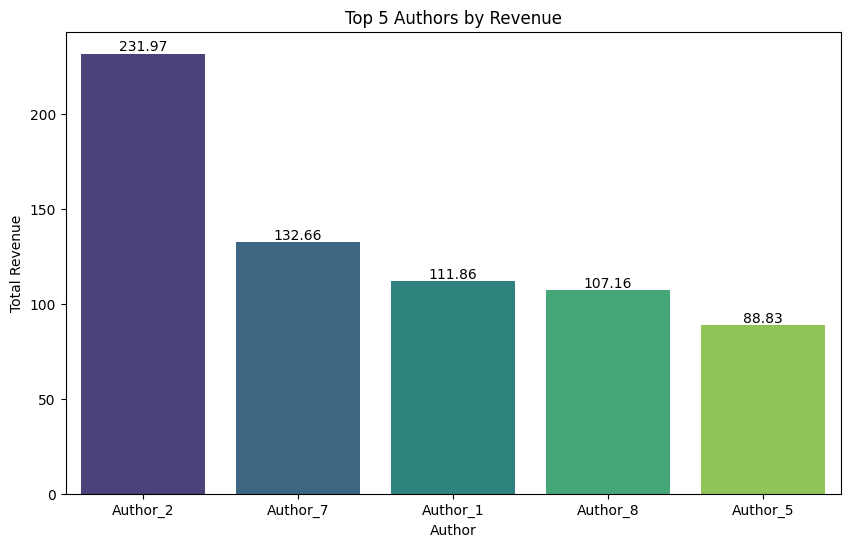

<ipython-input-31-0251d0890bc6>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=genres, y=quantities, palette='coolwarm')


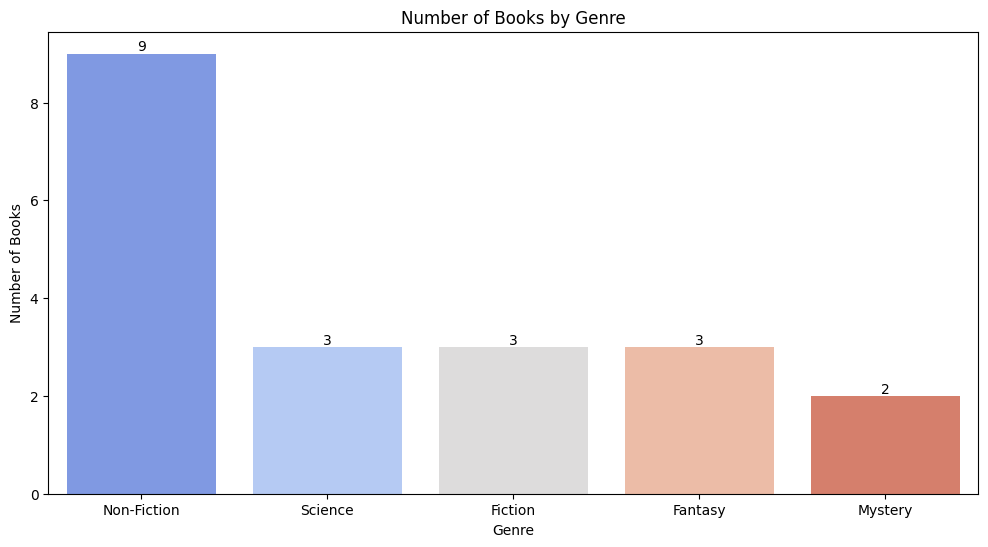

<ipython-input-31-0251d0890bc6>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=author_names_avg, y=average_prices, palette='magma')


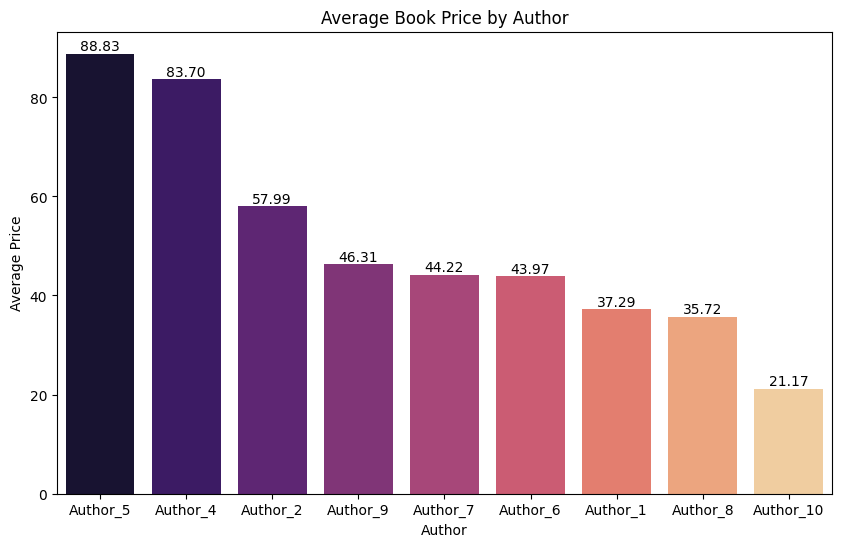

In [ ]:
# топ 5 авторов по выручке
author_names = [row['name'] for row in top5_authors_data]
total_prices = [row['total_price'] for row in top5_authors_data]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=author_names, y=total_prices, palette='viridis')
plt.title('Top 5 Authors by Revenue')
plt.xlabel('Author')
plt.ylabel('Total Revenue')
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')
plt.show()

# количество книг по жанрам
genres = [row['genre'] for row in quantity_by_genre_data]
quantities = [row['quantity'] for row in quantity_by_genre_data]

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=genres, y=quantities, palette='coolwarm')
plt.title('Number of Books by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Books')
for i in ax.containers:
    ax.bar_label(i, fmt='%d')
plt.show()

# средняя цена книг по авторам
author_names_avg = [row['name'] for row in avg_price_by_authors_data]
average_prices = [row['average_price'] for row in avg_price_by_authors_data]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=author_names_avg, y=average_prices, palette='magma')
plt.title('Average Book Price by Author')
plt.xlabel('Author')
plt.ylabel('Average Price')
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')
plt.show()